# Using python's Folium to create interactive maps

Folium is a python library built on top of leaflet.js. It is used to visualize data through interactive maps, choropleth visualization, as well as parsing markers on data. 

The blog version for this notebook can be found [here](https://www.nagarajbhat.com/post/folium-visualization/)
### What will be covered in this notebook?

- data preparation - merging,sorting, grouping using pandas. (step 1-5)
- barplot visualization using seaborn (step 6)
- creating maps using python's folium - tiles, circle marker, choropleth map, and geojson. (step7-9)
- creating labels on the choropleth map using geojsontooltip. (step 10)
- Displaying multiple data views on the same map using the "feature group" and control layer. (step 11)
- Calculate market share(step 12)
- Calculate the largest commodity in each district(step 13)
- Create markers and use custom icons. (step 14)

### Pitfalls to avoid
I broke my head for several hours so that you don't have to.
- Avoid using jupyter lab in chrome, use firefox instead. Chrome did not render large maps. This will be useful in step 11.
- While creating a choropleth map we will be using geojson data. Make sure the values in the key column (district name, or state) is the same across this file and the original data.
- folium.Choropleth() doesn't provide an option for creating labels on top, use geojsontooltip along with it to create labels.

 If you are not interested in the data preparation method, skip to the step 7 to start off with folium maps

#### Data
- You can find the data used in this notebook in the "data" folder.
- **References**:
    1. "CommMktArrivals2012.xls" - Karnataka Agriculture market data by [data.gov.in](https://data.gov.in/resources/karnataka-agricultural-market-data-2012) 
    2. "kar.json" - Geojson map data for karnakata by [Kenneth Mark Dsouza](https://github.com/inosaint) from [here](https://github.com/inosaint/StatesOfIndia/blob/master/karnataka.geojson).
        Some of the districts name were corrected to suit "CommMktArrivals2012.xls".
    3. "kar_latlong.xlsx" - Latitude and longitude for each district in karnataka. This file was created by me.

## Step 1 : Installation and import

Install folium,pandas using pip

- pip install folium
- pip install pandas

import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [39]:


import numpy as np
import pandas as pd

df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
df_sample['State FIPS Code'] = df_sample['State FIPS Code'].apply(lambda x: str(x).zfill(2))
df_sample['County FIPS Code'] = df_sample['County FIPS Code'].apply(lambda x: str(x).zfill(3))
df_sample['FIPS'] = df_sample['State FIPS Code'] + df_sample['County FIPS Code']

colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = list(np.linspace(1, 12, len(colorscale) - 1))
fips = df_sample['FIPS'].tolist()
values = df_sample['Unemployment Rate (%)'].tolist()



In [31]:
df_sample.head()

,LAUS Code,State FIPS Code,County FIPS Code,County Name/State Abbreviation,Year,Labor Force,Employed,Unemployed,Unemployment Rate (%),FIPS
0,CN0100100000000,01,001,"Autauga County, AL",2016,"25,649","24,297","1,352",5.3,01001
1,CN0100300000000,01,003,"Baldwin County, AL",2016,"89,931","85,061","4,870",5.4,01003
2,CN0100500000000,01,005,"Barbour County, AL",2016,"8,302","7,584",718,8.6,01005
3,CN0100700000000,01,007,"Bibb County, AL",2016,"8,573","8,004",569,6.6,01007
4,CN0100900000000,01,009,"Blount County, AL",2016,"24,525","23,171","1,354",5.5,01009


## Step 2: pick a data
Pick a data you are interested in. I've considered [agriculture market data from karnataka(2012)](https://data.gov.in/resources/karnataka-agricultural-market-data-2012).

In [54]:
data = pd.read_excel('data/CommMktArrivals2012.xls')
data.columns

Index(['District Name', 'Taluk Name', 'Market Name', 'Address', 'Telephone',
       'Commodity', 'Year', 'Month', 'Arrival', 'Unit'],
      dtype='object')

## Step 3: Data preparation 

- There are 156 Commodities in the data.We will only consider commodities whose units are in quintal,so other commodities such as coconut,Ox will be left out.This is done for the sake of uniformity.
- Also, we do not require all the columns. hence filter the columns needed.
- 'sum' function is used to obtain the sum of all items (our focus is on the 'Arrival') based on the groupings.


In [55]:
df = data.groupby(['Commodity','District Name','Unit'],as_index=False)
df = df.sum().filter(["Commodity","District Name","Arrival","Unit"])
df_quintal = df[df["Unit"]=="Quintal   "]
df_quintal.head()

,Commodity,District Name,Arrival,Unit
0,Alasande Gram,Bagalakot,2258,Quintal
1,Alasande Gram,Bangalore Urban•,34328,Quintal
2,Alasande Gram,Chamarajanagar,192,Quintal
3,Alasande Gram,Chickmagalur,3,Quintal
4,Alasande Gram,Davanagere,5875,Quintal


Note that **'Arrival'** here refers to the arrival of commodities at a place for sale, from various source such as villages, storages,etc.

Commodities which will be left out of the analysis are:

In [56]:
df_notquintal = df[df["Unit"]!="Quintal   "]
df_notquintal.Commodity.unique()

array(['Ash Gourd', 'Bull  ', 'Calf  ', 'Coconut  ', 'Cow  ', 'Goat  ',
       'He Baffalo  ', 'Ox  ', 'Ram  ', 'She Baffalo  ', 'She Goat  ',
       'Sheep  ', 'Tender Coconut'], dtype=object)

### Step 4: Latitude and longitude
Not all datasets come with geographical values. So we create  an excel file and populate districts with their latitude and longitude values.


In [57]:
kar_latlong = pd.read_excel("./data/karnataka_latlong.xlsx")
kar_latlong.head()

,District Name,Latitude,Longitude
0,Bagalakot,16.179200,75.699400
1,Bangalore Urban•,12.976750,77.575279
2,Chamarajanagar,11.926147,76.943733
3,Chickmagalur,13.444570,75.685380
4,Davanagere,14.464408,75.921761


Now, merge this file with the original data df

In [58]:
df_merged = pd.merge(df_quintal,kar_latlong)
print(df_merged.dtypes)
df_merged.head()

Commodity         object
District Name     object
Arrival            int64
Unit              object
Latitude         float64
Longitude        float64
dtype: object


,Commodity,District Name,Arrival,Unit,Latitude,Longitude
0,Alasande Gram,Bagalakot,2258,Quintal,16.1792,75.6994
1,Bajra,Bagalakot,127672,Quintal,16.1792,75.6994
2,Bengalgram,Bagalakot,16775,Quintal,16.1792,75.6994
3,Castor Seed,Bagalakot,100,Quintal,16.1792,75.6994
4,Chilly Red,Bagalakot,2909,Quintal,16.1792,75.6994


Note that we will be using this data - "df_merged" thoroughout this example.

## Step 5: Obtain Geojson data

Geojson is a popular format for representing geographical features.Its a Json file which contains polygon structures of states, districts, etc.

Make sure the key column in geojson data, such as "District Name" or " id" , matches with the original data.If not, modify it to match.


In [59]:
state_geo = f'./data/kar.json'
sg = pd.read_json(state_geo)
sg.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'id': 215, 'properties': {..."
1,FeatureCollection,"{'type': 'Feature', 'id': 216, 'properties': {..."
2,FeatureCollection,"{'type': 'Feature', 'id': 217, 'properties': {..."
3,FeatureCollection,"{'type': 'Feature', 'id': 218, 'properties': {..."
4,FeatureCollection,"{'type': 'Feature', 'id': 219, 'properties': {..."


## Step 6: Bar graph to visualise top 10 commodities
This is to plot the top ten commodities, with the criteria of highest arrivals. We group the elements by commodity, unit and sort them in descending order of arrival quantity.

In [60]:
dfg  = df_merged.groupby(['Commodity','Unit'],as_index=False)

topten_df = dfg.sum().sort_values(by='Arrival',ascending=False).head(10)
topten_df

,Commodity,Unit,Arrival,Latitude,Longitude
102,Paddy,Quintal,18554513,380.467137,2060.111836
84,Maize,Quintal,15460281,401.154348,2137.423769
99,Onion,Quintal,9826018,368.514132,1982.113841
111,Rice,Quintal,9159723,368.129609,1984.904080
107,Potato,Quintal,4467185,260.171524,1451.324285
60,Green Ginger,Quintal,2952505,240.684788,1373.686010
44,Cotton,Quintal,2861896,310.754192,1599.291974
135,Tomato,Quintal,2858265,240.716868,1377.507581
5,Arecanut,Quintal,2696704,227.213780,1294.990255
136,Tur,Quintal,2562682,308.087800,1602.387911


Then we use seaborn library's barplot  to plot. As we can see the top  Commodities from karnataka are paddy,maize,onion,rice,potato,cotton,green ginger,tomato,arecanut and tur.

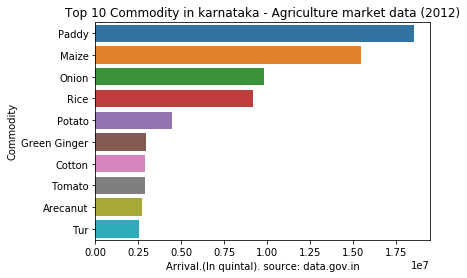

In [61]:
fig = sns.barplot(topten_df['Arrival'],topten_df['Commodity'])
plt.title("Top 10 Commodity in karnataka - Agriculture market data (2012)")
plt.xlabel("Arrival.(In quintal). source: data.gov.in")
plt.savefig("img/step6_topten",bbox_inches="tight")
plt.show(fig)


## Step 7 : Creating basic folium map

Foilum can be used to visualize geographical data.

In [62]:
f = folium.Figure(width=600, height=400)
m = folium.Map(location=[df_merged['Latitude'].mean(),df_merged['Longitude'].mean()],  
               zoom_start=5.2,tiles='cartodbpositron').add_to(f)
m.save('html/basicmap.html')
m

# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src="html/basicmap.html" width=700 height=450></iframe>')

C:\Users\Shoaib\Anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning:

Consider using IPython.display.IFrame instead



folium.Map() can be used to create a map.Here are few important parameters it takes:
- location: give the latitude and longitude value for the center of the map.
- zoom_start: indicates the starting zoom point.
- tiles: for the map style.The default tiles are set to 'OpenStreetMap', but 'Stamen Terrain','Stamen Toner','Stamen Watercolor', 'cartodbpositron', 'cartodbdark_matter', and many other tiles are built-in.
- add_to() : add_to method is used to add the function to the map or other functions.
- folium.Figure(): It is generally used if you want to set the height and width of the figure, but this is not necessary to create a map, just add_to(m) instead.

## Step 8 : Adding folium circle marker

Circle marker can be added using folium.Circle() function.
We will filter out paddy Arrival data and link it to the circle

In [63]:
m = folium.Map(location=[df_merged['Latitude'].mean(),df_merged['Longitude'].mean()],  
               zoom_start=6.2,tiles='cartodbpositron')
paddy = df_merged[df_merged["Commodity"]=="Paddy"]
data_cm = paddy

for i in range(0,len(data_cm)):
   folium.Circle(
     location=[data_cm.iloc[i]['Latitude'], data_cm.iloc[i]['Longitude']],
      popup=str(data_cm.iloc[i]['District Name'])+":"+str(data_cm.iloc[i]['Arrival']),
      radius=float(data_cm.iloc[i]['Arrival']/75),
      color='crimson',
      fill=True,
      fill_color='blue'
   ).add_to(m)
m.save('html/step8_paddy.html')
m

# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=html/step8_paddy.html width=700 height=450></iframe>')

parameters in folium circle:
- popup: text to be pops up when the circle is clicked on.
- radius: radius of the circle. here we have linked it to the Arrival value of the paddy data.
    The bigger the circle, the more paddy arrives in that area.
    
As we can see circle marker may not be the best representation for this scenario.
As the circle radius is the value of arrival and doesn't indicate the appropriate boundaries for the districts.
Hence we will make use of choropleth.

## Step 9: Create a Choropleth map
- Choropleth is a type of thematic map in which areas (such as districts or state) are colored with different shades of a color corresponding to the density/quantity of the data it is linked to.
- create using folium.Choropleth()


In [64]:
m = folium.Map([15, 70], zoom_start=6,tiles='cartodbpositron')

arecanut = df_merged[df_merged["Commodity"]=="Arecanut"]
state_data = arecanut

choropleth = folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['District Name', 'Arrival'],
    key_on='feature.properties.NAME_2',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Arecanut Arrival(in Quintal)',
    highlight=True,
    line_color='black'
).add_to(m)

folium.LayerControl(collapsed=True).add_to(m)
m.save('html/step9_choropleth.html')

m
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=html/step9_choropleth.html width=700 height=450></iframe>')

## Step 10: Add label to choropleth using GeoJsonTooltip

- This is the most basic version of a GeoJsonTool tip
- add_child() function is used to add this under choropleth
- 'NAME_2' is a field from state_geo containing district names.

In [65]:
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['NAME_2'],labels=False)
)
m.save("html/step10_geojsontooltip.html")
m
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=html/step10_geojsontooltip.html width=700 height=450></iframe>')

### Step 11: displaying multiple data using feature group and layer control

- As we can see above we were able to visualize map for arecanut across Karnataka.
  - But what if we want to view paddy or maize?
  - Should we create separate maps for each?
  - Is there a way to view multiple commodities in a single map?
- The answer to this is using FeatureGroup.
- Multiple features can be passed to a single feature group to group them together
- And then multiple feature groups can be created and added to layer control
- this gives us an option to toggle different views.
- Tile layer option can be added for map themes
    - can be added using folium.Tilelayer()
    - make collapsed as False to display the option

Please note that execution of the following code could be very slow,
use firefox insteead of chrome, and reduce the number of commodities if you want quicker execution.

In [51]:
from branca.colormap import linear

m = folium.Map([15, 74], zoom_start=5.5,tiles=None,overlay=False)

#top 10 commodities
paddy = df_merged[df_merged["Commodity"]=="Paddy"]
maize = df_merged[df_merged["Commodity"]=="Maize"]
onion = df_merged[df_merged["Commodity"]=="Onion"]
rice = df_merged[df_merged["Commodity"]=="Rice"]
potato = df_merged[df_merged["Commodity"]=="Potato"]

cotton = df_merged[df_merged["Commodity"]=="Cotton"]
greenginger = df_merged[df_merged["Commodity"]=="Green Ginger"]
tomato = df_merged[df_merged["Commodity"]=="Tomato"]
arecanut = df_merged[df_merged["Commodity"]=="Arecanut"]
tur = df_merged[df_merged["Commodity"]=="Banana"]



# feature groups - for each commodity
feature_group0 = folium.FeatureGroup(name='paddy',overlay=False).add_to(m)
feature_group1= folium.FeatureGroup(name='maize',overlay=False).add_to(m)
feature_group2 = folium.FeatureGroup(name='onion',overlay=False).add_to(m)
feature_group3= folium.FeatureGroup(name='rice',overlay=False).add_to(m)
feature_group4 = folium.FeatureGroup(name='potato',overlay=False).add_to(m)
feature_group5 = folium.FeatureGroup(name='cotton',overlay=False).add_to(m)
feature_group6 = folium.FeatureGroup(name='Green Ginger',overlay=False).add_to(m)
feature_group7 = folium.FeatureGroup(name='Tomato',overlay=False).add_to(m)
feature_group8 = folium.FeatureGroup(name='Arecanut',overlay=False).add_to(m)
feature_group9 = folium.FeatureGroup(name='Tur',overlay=False).add_to(m)


fs = [feature_group0,feature_group1,feature_group2,feature_group3,feature_group4,feature_group5,
      feature_group6,feature_group7,feature_group8,feature_group9]
commodities = [paddy,maize,onion,rice,potato,cotton,greenginger,tomato,arecanut,tur]

#cycle through each commodity and add choropleth to corresposing feature groups
for i in range(len(commodities)): 
    choropleth1 = folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=commodities[i],
    columns=['District Name', 'Arrival'],
    key_on='feature.properties.NAME_2',
    fill_color='YlGn',
    nan_fill_color="black",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Arrival (in Quintal)',
    highlight=True,
    line_color='black').geojson.add_to(fs[i])
    
    #geojson for labels
    geojson1 = folium.GeoJson(data=state_geo,
               name='karnataka district',
                         smooth_factor=2,
               style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
                tooltip=folium.GeoJsonTooltip(fields=['NAME_2'],
                                              labels=False,
                                              sticky=True),
              highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                        
                       ).add_to(choropleth1)
    
#Color map to create legend 
colormap = linear.YlGn_09.scale(
df_merged.Arrival.min(),
df_merged.Arrival.max()).to_step(10)
colormap.caption = 'Arrival (in quintal)'
colormap.add_to(m)
   
# Add tiles
folium.TileLayer('OpenStreetMap',overlay=True,name="color mode").add_to(m)
folium.TileLayer('cartodbdark_matter',overlay=True,name="dark mode").add_to(m)
folium.TileLayer('cartodbpositron',overlay=True,name="light mode").add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save('html/step11_toptenmap.html')
m

# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=html/step11_toptenmap.html width=700 height=450></iframe>')

C:\Users\Shoaib\Anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning:

Consider using IPython.display.IFrame instead



## Step 12: Calculate market share - Percentage of Commodity in a district

This step is not necesary for visualisation, but the data can be used for insights

In [26]:
# percent of Paddy from Raichur
paddy = df_merged[df_merged["Commodity"]=="Paddy"]
paddy[paddy["District Name"]=="Raichur"].Arrival/paddy.Arrival.sum() *100

1441    20.285221
Name: Arrival, dtype: float64

In [27]:
## percent of Tomato from Kolar
tomato = df_merged[df_merged["Commodity"]=="Tomato"]
tomato[tomato["District Name"]=="Kolar"].Arrival/tomato.Arrival.sum() *100

1069    51.956799
Name: Arrival, dtype: float64

## step 13 : Calculate the largest commodity in each district
- Large number of commodities arrive at each district, we need to find the one with the largest arrival value
- We can use the resulting max_commodity data to place relevant commodity icons for each district in the next step.

In [28]:
max_commodity={}
#create list of unique districts
districts = df_merged["District Name"].unique()
for el in districts:
    #filter out data of each district
    df_dis = df_merged[df_merged["District Name"]==el]
    #obtain the commodity with maximum arrival in each district
    max_each_district  = df_dis[df_dis.Arrival == df_dis.Arrival.max()].Commodity.iloc[0]
    #fill it in max_commodity as district:max_commodity_for_each_district
    max_commodity[df_dis["District Name"].iloc[0]] = max_each_district
max_commodity


{'Bagalakot': 'Maize',
 'Bangalore Urban•': 'Onion',
 'Chamarajanagar': 'Paddy',
 'Chickmagalur': 'Paddy',
 'Davanagere': 'Maize',
 'Dharwad': 'Onion',
 'Gadag': 'Maize',
 'Gulbarga': 'Tur',
 'Hassan': 'Green Ginger',
 'Haveri': 'Maize',
 'MANDYA': 'Jaggery',
 'Mysore': 'Paddy',
 'Ramnagar': 'Mango',
 'Shimoga': 'Maize',
 'Tumukur': 'Copra',
 'Udupi': 'Arecanut',
 'Bangalore Rural': 'Maize',
 'Kolar': 'Tomato',
 'Belgaum': 'Onion',
 'Chickballapur': 'Maize',
 'Kodagu': 'Green Ginger',
 'Chitradurga': 'Maize',
 'Dakshina Kannada': 'Arecanut',
 'Uttara Kannada': 'Paddy',
 'Bidar': 'Tur',
 'Bellary': 'Paddy',
 'Bijapur': 'Cotton',
 'Koppal': 'Paddy',
 'Raichur': 'Paddy'}

## Step 14: Create markers and use custom icons

- Custom icon can be created using a image file, and used as a marker.
- Each icon is dynamically taken depending upon the largest commodity name for each district.

In [30]:

m = folium.Map(location=[df_merged['Latitude'].mean()+1,df_merged['Longitude'].mean()],  
               zoom_start=5.5,tile=None)

data_cm = kar_latlong

geojson = folium.GeoJson(data=state_geo,
                         smooth_factor=2,
               style_function=lambda x: {'color':'black','fillColor':'green','weight':1},
                tooltip=folium.GeoJsonTooltip(fields=['NAME_2'],
                                              labels=False,
                                              sticky=True),
              highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                       ).add_to(m)
# marker and icon
for i in range(0,len(data_cm)):
    #changing file name depending upon largest commodity for the district
    icon_image = "./img/icons/"+str(max_commodity[data_cm.iloc[i]['District Name']])+".png"
    icon = folium.CustomIcon(
    icon_image,
    icon_size=(25, 25),
    icon_anchor=(15, 15),
    popup_anchor=(-3, -76)
)
    folium.Marker(
    location=[data_cm.iloc[i]['Latitude'], data_cm.iloc[i]['Longitude']],
    icon=icon,
    radius=float(15000.0),
    popup=str(data_cm.iloc[i]['District Name'])+":"+str(max_commodity[data_cm.iloc[i]['District Name']])
    ).add_to(m)
    
# Add tiles
folium.TileLayer('cartodbdark_matter',overlay=True,name="dark mode").add_to(m)
folium.TileLayer('cartodbpositron',overlay=True,name="light mode").add_to(m)
folium.TileLayer('OpenStreetMap',overlay=True,name="open street").add_to(m)

folium.LayerControl(collapsed=True).add_to(m)

m.save('html/step14_icon_commodity.html')
m


# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=html/step14_icon_commodity.html width=700 height=450></iframe>')


In this post we learnt how to use folium for interactive maps, prepare the data using pandas, use geojson data, create choropelth map and add labels, use multiple data layers, and add custom markers.
For more information on folium check out their official [documentation](https://python-visualization.github.io/folium/).